# Setup

## imports

In [60]:
import pandas as pd
import os
from pandasql import sqldf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# import boto3

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

pysqldf = lambda q: sqldf(q, globals())

In [33]:
# tracking2020 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2020.csv')
# tracking2019 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2019.csv')
# tracking2018 = pd.read_csv('/Users/logan.larson/code/nfl-big-data-bowl-2022/tracking2018.csv')
# tracking = tracking2020.append(tracking2019).append(tracking2018)

# tracking.head(3) 
# # 3 minutes

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2021-01-03T18:03:02.200,61.21,46.77,0.08,0.13,0.01,186.21,144.73,None,42901.0,Dean Marlowe,31.0,SS,home,1,2021010300,40,left
1,2021-01-03T18:03:02.300,61.22,46.77,0.11,0.19,0.01,184.87,126.09,None,42901.0,Dean Marlowe,31.0,SS,home,2,2021010300,40,left
2,2021-01-03T18:03:02.400,61.23,46.76,0.10,0.18,0.01,183.38,108.95,None,42901.0,Dean Marlowe,31.0,SS,home,3,2021010300,40,left


In [ ]:
# newdf = df.query('specialTeamsPlayType == "Kickoff" & specialTeamsResult == "Return"')

In [ ]:
# newdf.head(4)

In [66]:
plays = pd.read_csv('plays.csv'); plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,"J.Elliott kicks 65 yards from PHI 35 to end zone, Touchback.",1,0,0,PHI,Kickoff,Touchback,44966.0,NaN,NaN,PHI,35,15:00:00,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Center-R.Lovato. J.Hardy to ATL 41 for 5 yards (K.Grugier-Hill). PENALTY on PHI-S.Gibson, Unsportsmanlike Conduct, 15 yards, enforced at ATL 41.",1,4,4,PHI,Punt,Return,45603.0,42450,NaN,PHI,8,09:20:00,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Center-J.Overbaugh, Holder-M.Bosher.",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,NaN,NaN,PHI,3,05:03:00,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,"M.Bosher kicks 64 yards from ATL 35 to PHI 1. S.Gibson to PHI 31 for 30 yards (D.Kazee, D.Riley).",1,0,0,ATL,Kickoff,Return,37267.0,44979,NaN,ATL,35,05:01:00,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, Center-R.Lovato, Touchback.",1,4,18,PHI,Punt,Touchback,45603.0,NaN,NaN,PHI,35,00:33:00,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


In [67]:
df2 = plays.query('specialTeamsPlayType == "Kickoff" & specialTeamsResult == "Return"')[['gameId', 'playId', 'playResult']]
df2['fname'] = df2.apply(lambda row: str(row.gameId) + '_' + str(row.playId) + '.png', axis=1)
df2['label'] = df2.apply(lambda row: 1 if row.playResult < 40 else 0 , axis=1)
df2.head()

,gameId,playId,playResult,fname,label
3,2018090600,677,34,2018090600_677.png,1
9,2018090600,1606,60,2018090600_1606.png,0
24,2018090900,36,45,2018090900_36.png,0
26,2018090900,400,33,2018090900_400.png,1
39,2018090900,1992,40,2018090900_1992.png,0


In [68]:
df2.label.sum()
   

1281

In [69]:
len(df2)

2921

In [78]:
!ls data/kickoffs/v1 | wc -l

2921


In [35]:
# for gameId, playId, playResult, file, label in df2.itertuples(index=False):
#     home_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId} and team == "home"')
#     away_team_tracking = tracking.query(f'gameId == {gameId} and playId == {playId}  and team == "away"')

#     fig, ax = create_football_field()

#     home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
#     away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    
#     plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/{file}')
#     plt.close()

In [ ]:
pysqldf("""SELECT playResult, count(*)
       FROM plays 
       where specialTeamsResult = 'Return' and specialTeamsPlayType = 'Kickoff'
       group by 1
       """)


In [ ]:
pysqldf("""SELECT count(*)
       FROM plays 
       where specialTeamsResult = 'Return' and specialTeamsPlayType = 'Kickoff'
       and playResult < 40
       """)


# simulating individual plays

In [ ]:
def create_football_field(linenumbers=False,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='white', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

create_football_field()
plt.show()

In [ ]:
example_play_home = newdf.query('gameId == 2021010300 and playId == 395 and team == "home"')
example_play_away = newdf.query('gameId == 2021010300 and playId == 395 and team == "away"')

fig, ax = create_football_field()
example_play_home.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
example_play_away.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
plt.title('Game #2018111900 Play #5577 at Ball Snap')
plt.legend()
plt.show()


In [ ]:
newdf.query('gameId == 2021010300 and playId == 395 and team == "home"')


In [ ]:
def plot_presnap_alignment(df, gameId, playId):
    example_play_home = tracking2020.query(f'gameId == {gameID} and playId == {playId} and team == "home"')
    example_play_away = tracking2020.query(f'gameId == {gameID} and playId == {playId} and team == "away"')

    fig, ax = create_football_field()
    example_play_home.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
    example_play_away.query('event == "ball_snap"').plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
    plt.title(f'Game {gameID} Play {playId} at Ball Snap')
    plt.legend()
    plt.show()


In [ ]:
example_play_home = newdf.query('gameId == 2021010300 and playId == 395 and team == "home"')
example_play_away = newdf.query('gameId == 2021010300 and playId == 395 and team == "away"')

fig, ax = create_football_field()
example_play_home.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
example_play_away.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
plt.title('Game #2018111900 Play #5577')
plt.legend()
plt.show()


# generate photo dataset

In [ ]:
df = pd.DataFrame()
for gameId, playId in play_type.itertuples(index=False):
    home_team_tracking = newdf.query(f'gameId == {gameId} and playId == {playId} and team == "home"')
    away_team_tracking = newdf.query(f'gameId == {gameId} and playId == {playId}  and team == "away"')

    fig, ax = create_football_field()

    home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
    away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')
    filename = f'{gameId}_{playId}'
    plt.savefig(f'/Users/logan.larson/code/nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/{filename}')




In [ ]:
q = """SELECT distinct gameId, playId, max(case when playResult < 0 then 1 else 0 end) as td_ind
       FROM newdf
       """
distinct_kickoffs = pysqldf(q)
distinct_kickoffs


In [ ]:

df= newdf[['gameId', 'playId', 'playResult']]

In [ ]:
import re
# for filename in os.listdir('../datasets/kickoff_returns_v1'):
for filename in os.listdir():
    # if re.findall(r'(.+)_\d+.png$', filename) == 1:
    if filename.startswith('1_'):
        new_fname = filename.lstrip('1_')
    else:
        new_fname = filename.lstrip('0_')
    os.rename(filename, new_fname)

In [ ]:
df = pd.DataFrame(columns=['fname', 'label'])
for filename in os.listdir():
    df = df.append([])


In [ ]:
home_team_tracking = newdf.query(f'gameId == 2018090900 and playId == 36 and team == "home"')
away_team_tracking = newdf.query(f'gameId == {gameId} and playId == {playId}  and team == "away"')

fig, ax = create_football_field()

home_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=1, legend='Away')
away_team_tracking.plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=1, legend='Home')



In [34]:
tracking.query(f'gameId == 2018090900')

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
12121207,2018-09-09T17:02:34.500,79.59,25.52,4.73,1.36,0.47,340.37,304.88,None,33469.0,Stephen Hauschka,4.0,K,away,1,2018090900,36,left
12121208,2018-09-09T17:02:34.600,79.20,25.79,4.91,1.28,0.48,347.77,304.51,None,33469.0,Stephen Hauschka,4.0,K,away,2,2018090900,36,left
12121209,2018-09-09T17:02:34.700,78.78,26.08,5.09,1.14,0.50,336.03,304.63,None,33469.0,Stephen Hauschka,4.0,K,away,3,2018090900,36,left
12121210,2018-09-09T17:02:34.800,78.35,26.37,5.21,0.87,0.52,316.94,303.82,None,33469.0,Stephen Hauschka,4.0,K,away,4,2018090900,36,left
12121211,2018-09-09T17:02:34.900,77.91,26.65,5.26,0.69,0.52,315.04,302.55,None,33469.0,Stephen Hauschka,4.0,K,away,5,2018090900,36,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12199770,2018-09-09T20:18:04.200,86.76,56.51,3.08,3.15,0.33,NaN,NaN,None,NaN,football,NaN,NaN,football,97,2018090900,4464,right
12199771,2018-09-09T20:18:04.300,87.01,56.66,2.79,2.89,0.29,NaN,NaN,None,NaN,football,NaN,NaN,football,98,2018090900,4464,right
12199772,2018-09-09T20:18:04.400,87.23,56.78,2.34,3.14,0.25,NaN,NaN,None,NaN,football,NaN,NaN,football,99,2018090900,4464,right
12199773,2018-09-09T20:18:04.500,87.41,56.90,2.04,2.89,0.22,NaN,NaN,None,NaN,football,NaN,NaN,football,100,2018090900,4464,right


In [67]:
# from pathlib import Path
path = 'nfl-big-data-bowl-2022/datasets/kickoff_returns_v1'
p = Path(path)

In [68]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import warnings
import os
warnings.filterwarnings('ignore')


In [69]:
p.ls()

(#2922) [Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2019120111_3957.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2019120813_2286.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2019120811_3120.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2020092707_428.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2020122713_1980.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2020110809_2494.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2018090906_1694.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2019102009_972.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2019110303_2346.png'),Path('nfl-big-data-bowl-2022/datasets/kickoff_returns_v1/2018090912_1762.png')...]

In [70]:
df3 = df2[['fname', 'label']]
df3.head()

,fname,label
3,2018090600_677.png,1
9,2018090600_1606.png,0
24,2018090900_36.png,0
26,2018090900_400.png,1
39,2018090900_1992.png,0


In [72]:
from fastai.vision.all import *
dls = ImageDataLoaders.from_df(df=df3, path=p)
                              #  valid_col='is_valid', 
                              #  label_delim=' ',
                              #  item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

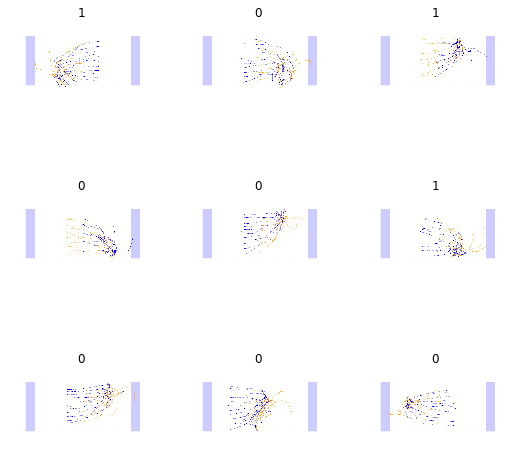

In [73]:
dls.show_batch()